## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp032'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

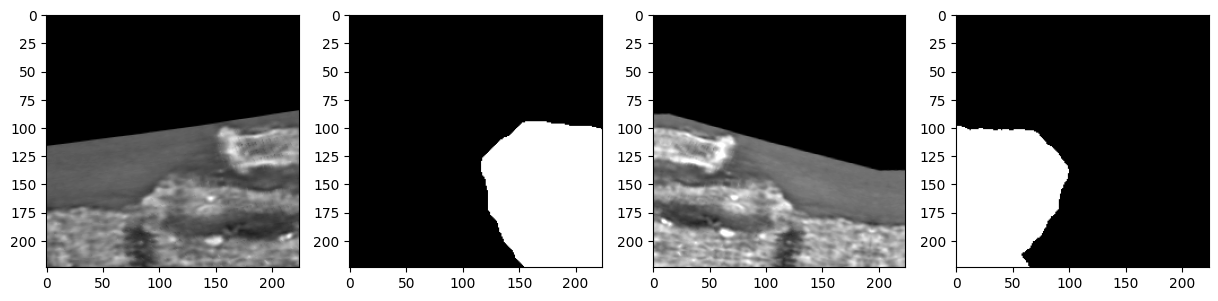

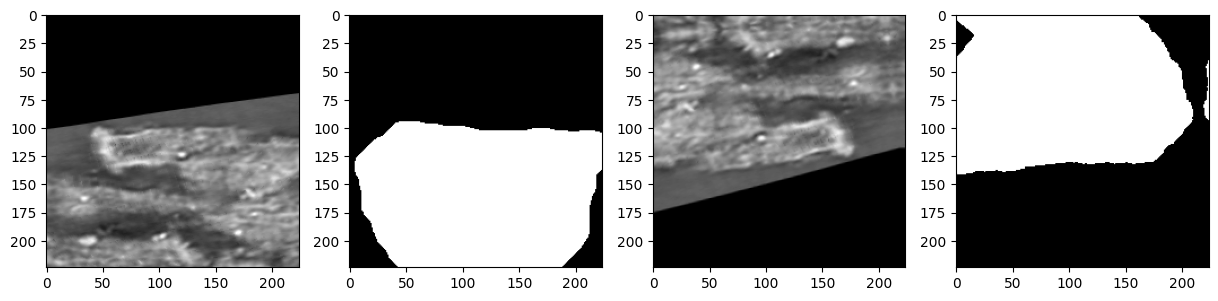

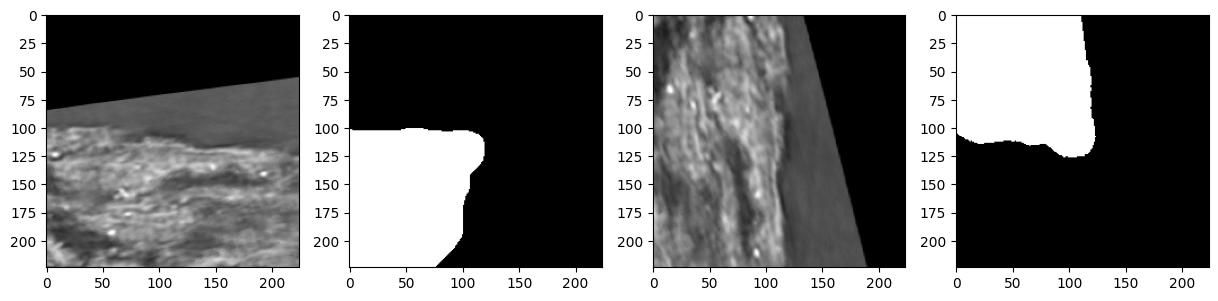

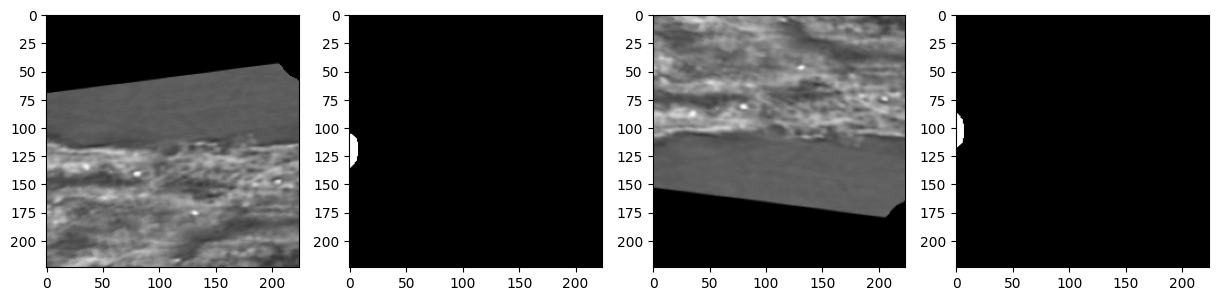

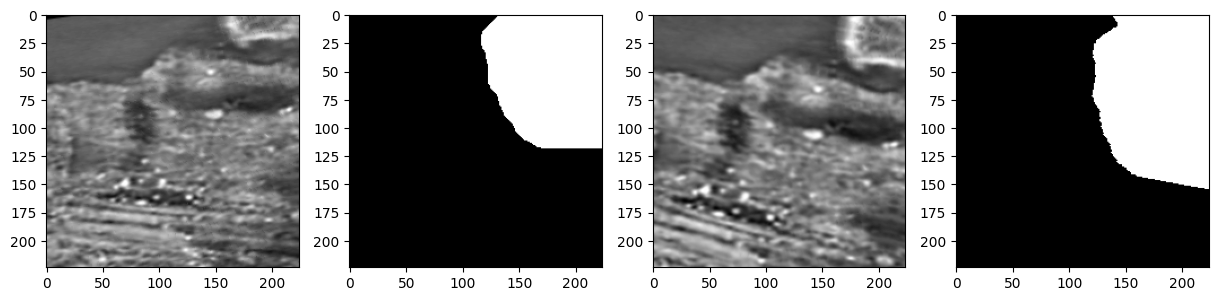

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

53880

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:
class FBetaLoss(nn.Module):
    def __init__(self, smooth: float = 1e-6, beta: float = 0.5):
        super().__init__()
        self.smooth = smooth
        self.beta = beta

    def forward(self, pred: torch.Tensor, true: torch.Tensor):
        pred_prob = torch.sigmoid(pred)
        if true.sum() == 0 and pred_prob.sum() == 0:
            return 0.0
        y_true_count = true.sum()
        ctp = (pred_prob * true).sum()
        cfp = (pred_prob * (1 - true)).sum()
        beta_squared = self.beta * self.beta

        c_precision = ctp / (ctp + cfp + self.smooth)
        c_recall = ctp / (y_true_count + self.smooth)
        fbeta = (
            (1 + beta_squared)
            * (c_precision * c_recall)
            / (beta_squared * c_precision + c_recall + self.smooth)
        )

        return 1 - fbeta

In [30]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
FBetaLoss_ = FBetaLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * FBetaLoss_(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    # return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [32]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [33]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [34]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501575976261861
th: 0.15, fbeta: 0.09506041269422419
th: 0.2, fbeta: 0.13802397453316112
th: 0.25, fbeta: 0.15451744430032882
th: 0.3, fbeta: 0.1788015677492402
th: 0.35, fbeta: 0.21013571064197736
th: 0.4, fbeta: 0.24986882866738963
th: 0.45, fbeta: 0.29205518026647137


best_th: 0.5, fbeta: 0.33313977878423034
Epoch 1 - avg_train_loss: 0.7168  avg_val_loss: 0.6564  time: 160s
Epoch 1 - avgScore: 0.3331
Epoch 1 - Save Best Score: 0.3331 Model
Epoch 1 - Save Best Loss: 0.6564 Model


th: 0.5, fbeta: 0.33313977878423034


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.0950271484924386
th: 0.15, fbeta: 0.14440019039156282
th: 0.2, fbeta: 0.17994539262857331
th: 0.25, fbeta: 0.2324582686889
th: 0.3, fbeta: 0.2717872978551629
th: 0.35, fbeta: 0.3036547295475031
th: 0.4, fbeta: 0.33358347255358106
th: 0.45, fbeta: 0.3605475150816069


best_th: 0.5, fbeta: 0.38854169737671174
Epoch 2 - avg_train_loss: 0.6087  avg_val_loss: 0.6112  time: 163s
Epoch 2 - avgScore: 0.3885
Epoch 2 - Save Best Score: 0.3885 Model
Epoch 2 - Save Best Loss: 0.6112 Model


th: 0.5, fbeta: 0.38854169737671174


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.33078885741672054
th: 0.15, fbeta: 0.39028263046958317
th: 0.2, fbeta: 0.4245265994562494
th: 0.25, fbeta: 0.45049976232261696
th: 0.3, fbeta: 0.47248392618261065
th: 0.35, fbeta: 0.4913389447578998
th: 0.4, fbeta: 0.508067988378728
th: 0.45, fbeta: 0.5215027984611187


best_th: 0.5, fbeta: 0.5334243975908163
Epoch 3 - avg_train_loss: 0.5204  avg_val_loss: 0.4803  time: 166s
Epoch 3 - avgScore: 0.5334
Epoch 3 - Save Best Score: 0.5334 Model
Epoch 3 - Save Best Loss: 0.4803 Model


th: 0.5, fbeta: 0.5334243975908163


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26902212104390283
th: 0.15, fbeta: 0.2902967099853359
th: 0.2, fbeta: 0.3071881100487527
th: 0.25, fbeta: 0.3230181287845798
th: 0.3, fbeta: 0.33675473470277856
th: 0.35, fbeta: 0.35054686693395054
th: 0.4, fbeta: 0.3651164623153285


best_th: 0.5, fbeta: 0.3950255235203915
Epoch 4 - avg_train_loss: 0.4507  avg_val_loss: 0.5365  time: 163s
Epoch 4 - avgScore: 0.3950


th: 0.45, fbeta: 0.3809160634157283
th: 0.5, fbeta: 0.3950255235203915


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44013106782334926
th: 0.15, fbeta: 0.4791133734876001
th: 0.2, fbeta: 0.5081893713342817
th: 0.25, fbeta: 0.5323287467355184
th: 0.3, fbeta: 0.5494187193006703
th: 0.35, fbeta: 0.5610413673865695
th: 0.4, fbeta: 0.5718974647324797
th: 0.45, fbeta: 0.58197665294348


best_th: 0.5, fbeta: 0.5851389309185622
Epoch 5 - avg_train_loss: 0.4165  avg_val_loss: 0.4544  time: 162s
Epoch 5 - avgScore: 0.5851
Epoch 5 - Save Best Score: 0.5851 Model
Epoch 5 - Save Best Loss: 0.4544 Model


th: 0.5, fbeta: 0.5851389309185622


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42061575253081784
th: 0.15, fbeta: 0.4451799678981109
th: 0.2, fbeta: 0.46684786714918425
th: 0.25, fbeta: 0.49249209247606807
th: 0.3, fbeta: 0.5114194428432193
th: 0.35, fbeta: 0.5246467077067832
th: 0.4, fbeta: 0.5373619471467099
th: 0.45, fbeta: 0.5499993831652201


best_th: 0.5, fbeta: 0.5578713784821215
Epoch 6 - avg_train_loss: 0.4085  avg_val_loss: 0.4668  time: 160s
Epoch 6 - avgScore: 0.5579


th: 0.5, fbeta: 0.5578713784821215


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4811756648175926
th: 0.15, fbeta: 0.5108649446617769
th: 0.2, fbeta: 0.5292819138986635
th: 0.25, fbeta: 0.5438509801486217
th: 0.3, fbeta: 0.5558830174459221
th: 0.35, fbeta: 0.5647907018418175
th: 0.4, fbeta: 0.5718521658647137
th: 0.45, fbeta: 0.5775379961021097


best_th: 0.5, fbeta: 0.5805168050083709
Epoch 7 - avg_train_loss: 0.3801  avg_val_loss: 0.4607  time: 160s
Epoch 7 - avgScore: 0.5805


th: 0.5, fbeta: 0.5805168050083709


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35306446512928935
th: 0.15, fbeta: 0.3753404175025486
th: 0.2, fbeta: 0.3898692026734996
th: 0.25, fbeta: 0.40429790260198895
th: 0.3, fbeta: 0.41910394096633236
th: 0.35, fbeta: 0.4330122073300932
th: 0.4, fbeta: 0.44474323184075065
th: 0.45, fbeta: 0.4563656181049559


best_th: 0.5, fbeta: 0.46944620095776624
Epoch 8 - avg_train_loss: 0.3629  avg_val_loss: 0.4929  time: 160s
Epoch 8 - avgScore: 0.4694


th: 0.5, fbeta: 0.46944620095776624


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4219795921294165
th: 0.15, fbeta: 0.44896518843347133
th: 0.2, fbeta: 0.46508733324067353
th: 0.25, fbeta: 0.47955545641804354
th: 0.3, fbeta: 0.4946249076534145
th: 0.35, fbeta: 0.5085265036137724
th: 0.4, fbeta: 0.5209170095924551
th: 0.45, fbeta: 0.5335550331260006


best_th: 0.5, fbeta: 0.5422336086365984
Epoch 9 - avg_train_loss: 0.3686  avg_val_loss: 0.4673  time: 159s
Epoch 9 - avgScore: 0.5422


th: 0.5, fbeta: 0.5422336086365984


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47086999598782026
th: 0.15, fbeta: 0.4931667336599744
th: 0.2, fbeta: 0.5095857743173071
th: 0.25, fbeta: 0.5237193021213059
th: 0.3, fbeta: 0.5358020720372252
th: 0.35, fbeta: 0.5437559424215922
th: 0.4, fbeta: 0.5503520652632699
th: 0.45, fbeta: 0.5554296823942974


best_th: 0.5, fbeta: 0.5580778145381702
Epoch 10 - avg_train_loss: 0.3285  avg_val_loss: 0.4690  time: 165s
Epoch 10 - avgScore: 0.5581


th: 0.5, fbeta: 0.5580778145381702


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4397555389439233
th: 0.15, fbeta: 0.45704921888790573
th: 0.2, fbeta: 0.4789898809465699
th: 0.25, fbeta: 0.507701465880681
th: 0.3, fbeta: 0.5264603683767166
th: 0.35, fbeta: 0.537427197840647
th: 0.4, fbeta: 0.5481846529443394
th: 0.45, fbeta: 0.5611834244121857


best_th: 0.5, fbeta: 0.5728729287238837
Epoch 11 - avg_train_loss: 0.3133  avg_val_loss: 0.4663  time: 164s
Epoch 11 - avgScore: 0.5729


th: 0.5, fbeta: 0.5728729287238837


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4351987586326695
th: 0.15, fbeta: 0.45636624924682245
th: 0.2, fbeta: 0.4736044810487945
th: 0.25, fbeta: 0.4920998711534673
th: 0.3, fbeta: 0.5065016093221786
th: 0.35, fbeta: 0.5166096878462755
th: 0.4, fbeta: 0.5246636214904056


best_th: 0.5, fbeta: 0.537419808073631
Epoch 12 - avg_train_loss: 0.3035  avg_val_loss: 0.4815  time: 169s
Epoch 12 - avgScore: 0.5374


th: 0.45, fbeta: 0.5331852234160674
th: 0.5, fbeta: 0.537419808073631


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41969421220978476
th: 0.15, fbeta: 0.43041979345051684
th: 0.2, fbeta: 0.4435778790769337
th: 0.25, fbeta: 0.4683351798360662
th: 0.3, fbeta: 0.4837885636145842
th: 0.35, fbeta: 0.49324091219111416
th: 0.4, fbeta: 0.5034015309932575


best_th: 0.5, fbeta: 0.5283184073437128
Epoch 13 - avg_train_loss: 0.2925  avg_val_loss: 0.4880  time: 171s
Epoch 13 - avgScore: 0.5283


th: 0.45, fbeta: 0.5176682863424018
th: 0.5, fbeta: 0.5283184073437128


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3443929735861522
th: 0.15, fbeta: 0.36219263930533474
th: 0.2, fbeta: 0.37285849046165637
th: 0.25, fbeta: 0.3861733920924482
th: 0.3, fbeta: 0.40293074584767974
th: 0.35, fbeta: 0.4163787089802629
th: 0.4, fbeta: 0.426580896931028
th: 0.45, fbeta: 0.4354970832335918


best_th: 0.5, fbeta: 0.4476813674656146
Epoch 14 - avg_train_loss: 0.2888  avg_val_loss: 0.5143  time: 167s
Epoch 14 - avgScore: 0.4477


th: 0.5, fbeta: 0.4476813674656146


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41352910318325986
th: 0.15, fbeta: 0.4256706144071783
th: 0.2, fbeta: 0.43691585917842746
th: 0.25, fbeta: 0.4523141154039818
th: 0.3, fbeta: 0.4663518741798282
th: 0.35, fbeta: 0.4778267365973401
th: 0.4, fbeta: 0.48966169900639334
th: 0.45, fbeta: 0.5021764128723067


best_th: 0.5, fbeta: 0.5142820120994821
Epoch 15 - avg_train_loss: 0.2748  avg_val_loss: 0.4916  time: 164s
Epoch 15 - avgScore: 0.5143


th: 0.5, fbeta: 0.5142820120994821


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.416326852441032
th: 0.15, fbeta: 0.4318766613898341
th: 0.2, fbeta: 0.4457157122170769
th: 0.25, fbeta: 0.46531256543149374
th: 0.3, fbeta: 0.4856797112259004
th: 0.35, fbeta: 0.4987680865804407
th: 0.4, fbeta: 0.5088849110912761
th: 0.45, fbeta: 0.5209891546905246


best_th: 0.5, fbeta: 0.5334402335246837
Epoch 16 - avg_train_loss: 0.2641  avg_val_loss: 0.4795  time: 165s
Epoch 16 - avgScore: 0.5334


th: 0.5, fbeta: 0.5334402335246837


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.412260009426885
th: 0.15, fbeta: 0.42711427709392286
th: 0.2, fbeta: 0.44281598267997796
th: 0.25, fbeta: 0.470379987025868
th: 0.3, fbeta: 0.49282180411265086
th: 0.35, fbeta: 0.5043941701393913
th: 0.4, fbeta: 0.5159409113761062
th: 0.45, fbeta: 0.5321304293409217


best_th: 0.5, fbeta: 0.5507444826717085
Epoch 17 - avg_train_loss: 0.2392  avg_val_loss: 0.4842  time: 161s
Epoch 17 - avgScore: 0.5507


th: 0.5, fbeta: 0.5507444826717085


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4171957045564635
th: 0.15, fbeta: 0.43080517163868604
th: 0.2, fbeta: 0.4451496838923658
th: 0.25, fbeta: 0.46746949333643134
th: 0.3, fbeta: 0.48116680908061515
th: 0.35, fbeta: 0.49181546262312564
th: 0.4, fbeta: 0.5013424579373414
th: 0.45, fbeta: 0.5134388133607783


best_th: 0.5, fbeta: 0.5286418436011076
Epoch 18 - avg_train_loss: 0.2317  avg_val_loss: 0.4906  time: 161s
Epoch 18 - avgScore: 0.5286


th: 0.5, fbeta: 0.5286418436011076


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.421232637442084
th: 0.15, fbeta: 0.43686250342656535
th: 0.2, fbeta: 0.45041538081325105
th: 0.25, fbeta: 0.4731826163957594
th: 0.3, fbeta: 0.49204241066275645
th: 0.35, fbeta: 0.5015762814211485
th: 0.4, fbeta: 0.5093769665951711
th: 0.45, fbeta: 0.5194304468894645


best_th: 0.5, fbeta: 0.5387140355887235
Epoch 19 - avg_train_loss: 0.2213  avg_val_loss: 0.4761  time: 162s
Epoch 19 - avgScore: 0.5387


th: 0.5, fbeta: 0.5387140355887235


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39338419842243383
th: 0.15, fbeta: 0.4073460231200429
th: 0.2, fbeta: 0.4204738022540216
th: 0.25, fbeta: 0.44025266167085086
th: 0.3, fbeta: 0.45655245271686473
th: 0.35, fbeta: 0.46688273020240706
th: 0.4, fbeta: 0.4763134215045403
th: 0.45, fbeta: 0.4882153496892445


best_th: 0.5, fbeta: 0.49837372530243434
Epoch 20 - avg_train_loss: 0.2173  avg_val_loss: 0.4936  time: 161s
Epoch 20 - avgScore: 0.4984


th: 0.5, fbeta: 0.49837372530243434


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44377670665137003
th: 0.15, fbeta: 0.45295623105316
th: 0.2, fbeta: 0.46218118700886857
th: 0.25, fbeta: 0.4830738086361562
th: 0.3, fbeta: 0.4979230416325091
th: 0.35, fbeta: 0.5009300893374399
th: 0.4, fbeta: 0.5038447901330902
th: 0.45, fbeta: 0.5093074837733735


best_th: 0.5, fbeta: 0.526637365117091
Epoch 21 - avg_train_loss: 0.2044  avg_val_loss: 0.4954  time: 162s
Epoch 21 - avgScore: 0.5266


th: 0.5, fbeta: 0.526637365117091


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42433486563435485
th: 0.15, fbeta: 0.4409342038473557
th: 0.2, fbeta: 0.4558702283050355
th: 0.25, fbeta: 0.4803675649238859
th: 0.3, fbeta: 0.5010519531537572
th: 0.35, fbeta: 0.5123693080721735
th: 0.4, fbeta: 0.5215498709698884
th: 0.45, fbeta: 0.5334169704704383


best_th: 0.5, fbeta: 0.5502865412343373
Epoch 22 - avg_train_loss: 0.1951  avg_val_loss: 0.4750  time: 162s
Epoch 22 - avgScore: 0.5503


th: 0.5, fbeta: 0.5502865412343373


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40840172027050187
th: 0.15, fbeta: 0.42223507159760776
th: 0.2, fbeta: 0.43482942296534527
th: 0.25, fbeta: 0.45782812362896125
th: 0.3, fbeta: 0.4772462612401299
th: 0.35, fbeta: 0.4874439490650605
th: 0.4, fbeta: 0.4959619013270523


best_th: 0.5, fbeta: 0.523477313305964
Epoch 23 - avg_train_loss: 0.1869  avg_val_loss: 0.4910  time: 163s
Epoch 23 - avgScore: 0.5235


th: 0.45, fbeta: 0.5064706635527682
th: 0.5, fbeta: 0.523477313305964


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41096565006120434
th: 0.15, fbeta: 0.42448669654650845
th: 0.2, fbeta: 0.43696660714676117
th: 0.25, fbeta: 0.46113217472009943
th: 0.3, fbeta: 0.48393957181485436
th: 0.35, fbeta: 0.4949928507869995
th: 0.4, fbeta: 0.502674047352141
th: 0.45, fbeta: 0.5126857211569267


best_th: 0.5, fbeta: 0.5298700402121586
Epoch 24 - avg_train_loss: 0.1767  avg_val_loss: 0.4881  time: 161s
Epoch 24 - avgScore: 0.5299


th: 0.5, fbeta: 0.5298700402121586


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4117924159085972
th: 0.15, fbeta: 0.4268048442969689
th: 0.2, fbeta: 0.4402355618313888
th: 0.25, fbeta: 0.4655132351362154
th: 0.3, fbeta: 0.4827672809561793
th: 0.35, fbeta: 0.491713435022458
th: 0.4, fbeta: 0.5003760910914624
th: 0.45, fbeta: 0.5099931624388597


best_th: 0.5, fbeta: 0.523465449415662
Epoch 25 - avg_train_loss: 0.1735  avg_val_loss: 0.4925  time: 161s
Epoch 25 - avgScore: 0.5235


th: 0.5, fbeta: 0.523465449415662


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41785991212881607
th: 0.15, fbeta: 0.4311793487170635
th: 0.2, fbeta: 0.4424561555592964
th: 0.25, fbeta: 0.464665864385852
th: 0.3, fbeta: 0.48280586277314147
th: 0.35, fbeta: 0.49143064978204004
th: 0.4, fbeta: 0.4976608872824098
th: 0.45, fbeta: 0.5053254769154384


best_th: 0.5, fbeta: 0.5201011440108378
Epoch 26 - avg_train_loss: 0.1719  avg_val_loss: 0.4967  time: 161s
Epoch 26 - avgScore: 0.5201


th: 0.5, fbeta: 0.5201011440108378


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40150752749257795
th: 0.15, fbeta: 0.41480721050239017
th: 0.2, fbeta: 0.4265773705770594
th: 0.25, fbeta: 0.45138395627172195
th: 0.3, fbeta: 0.4715918482631173
th: 0.35, fbeta: 0.4802495032477797
th: 0.4, fbeta: 0.4870817898059256
th: 0.45, fbeta: 0.49568402816527163


best_th: 0.5, fbeta: 0.5127423073049943
Epoch 27 - avg_train_loss: 0.1634  avg_val_loss: 0.4975  time: 162s
Epoch 27 - avgScore: 0.5127


th: 0.5, fbeta: 0.5127423073049943


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41946581742687417
th: 0.15, fbeta: 0.4312945698319141
th: 0.2, fbeta: 0.4435368936526338
th: 0.25, fbeta: 0.47015120291992757
th: 0.3, fbeta: 0.4884580063674824
th: 0.35, fbeta: 0.49706807891966853
th: 0.4, fbeta: 0.5045003440751287


best_th: 0.5, fbeta: 0.5372567730306504
Epoch 28 - avg_train_loss: 0.1643  avg_val_loss: 0.4918  time: 161s
Epoch 28 - avgScore: 0.5373


th: 0.45, fbeta: 0.5155005277618994
th: 0.5, fbeta: 0.5372567730306504


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40069620342265716
th: 0.15, fbeta: 0.41279522700253
th: 0.2, fbeta: 0.42433237284897557
th: 0.25, fbeta: 0.4473773329158713
th: 0.3, fbeta: 0.46945258854999994
th: 0.35, fbeta: 0.4802797473424086
th: 0.4, fbeta: 0.4892034970515137


best_th: 0.5, fbeta: 0.5162483289431936
Epoch 29 - avg_train_loss: 0.1617  avg_val_loss: 0.4968  time: 161s
Epoch 29 - avgScore: 0.5162


th: 0.45, fbeta: 0.49776365737460515
th: 0.5, fbeta: 0.5162483289431936


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40114519537047194
th: 0.15, fbeta: 0.4162859329620966
th: 0.2, fbeta: 0.42912694217578184
th: 0.25, fbeta: 0.4506859432652966
th: 0.3, fbeta: 0.4700101789154839
th: 0.35, fbeta: 0.48300830255064586
th: 0.4, fbeta: 0.49189796377782713


best_th: 0.5, fbeta: 0.5190381159198109
Epoch 30 - avg_train_loss: 0.1598  avg_val_loss: 0.4935  time: 162s
Epoch 30 - avgScore: 0.5190


th: 0.45, fbeta: 0.5013272776882639
th: 0.5, fbeta: 0.5190381159198109


In [35]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [36]:
mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.44013106782334926
th: 0.15, fbeta: 0.4791133734876001
th: 0.2, fbeta: 0.5081893713342817
th: 0.25, fbeta: 0.5323287467355184
th: 0.3, fbeta: 0.5494187193006703
th: 0.35, fbeta: 0.5610413673865695
th: 0.4, fbeta: 0.5718974647324797
th: 0.45, fbeta: 0.58197665294348


best_th: 0.5, fbeta: 0.5851389309185622


th: 0.5, fbeta: 0.5851389309185622


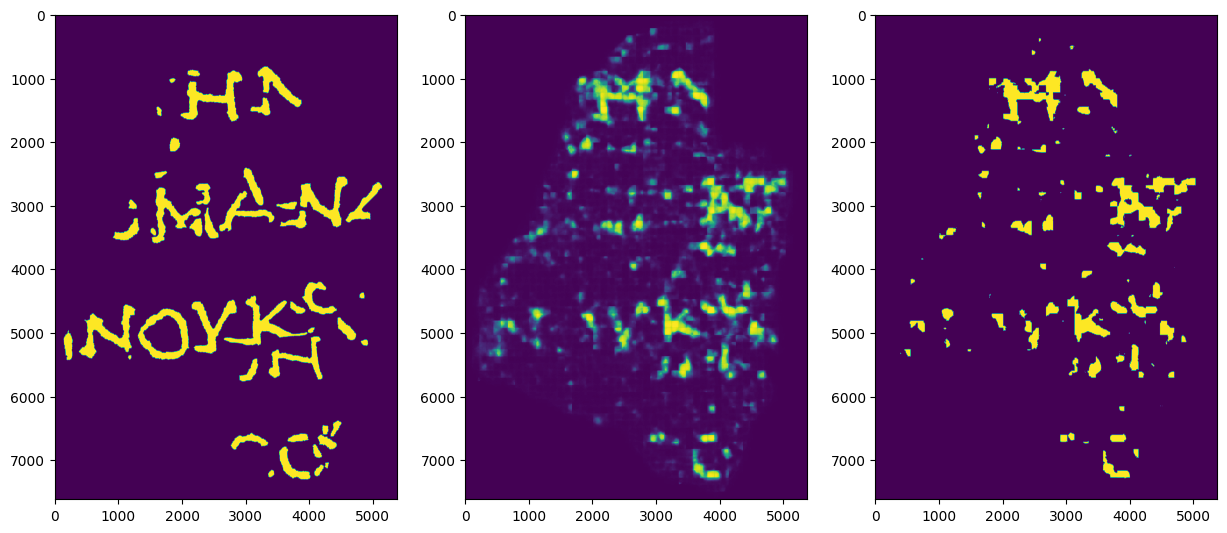

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([33270848.,  2447705.,   950175.,   568563.,   434710.,   333054.,
          273470.,   239708.,   220682.,   203667.,   168536.,   150729.,
          143227.,   145443.,   158679.,   195302.,   240335.,   290759.,
          268605.,   239419.]),
 array([1.40165607e-05, 4.99761276e-02, 9.99382387e-02, 1.49900350e-01,
        1.99862461e-01, 2.49824572e-01, 2.99786683e-01, 3.49748794e-01,
        3.99710905e-01, 4.49673016e-01, 4.99635127e-01, 5.49597239e-01,
        5.99559350e-01, 6.49521461e-01, 6.99483572e-01, 7.49445683e-01,
        7.99407794e-01, 8.49369905e-01, 8.99332016e-01, 9.49294127e-01,
        9.99256238e-01]),
 <BarContainer object of 20 artists>)

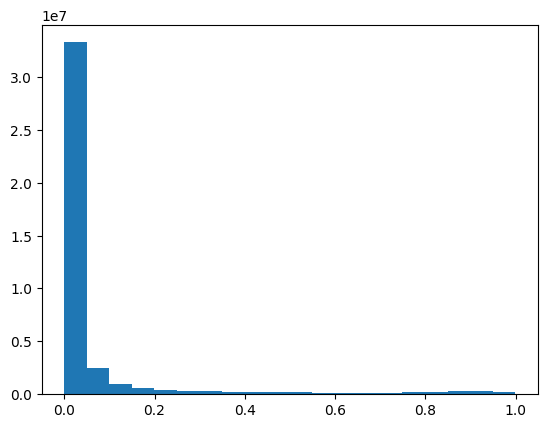

In [39]:
plt.hist(mask_pred.flatten(), bins=20)

In [40]:
# GPU VRAM 5.2GB/16.0GB A4000